In [1]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import scipy

Not running in Google Colab


In [14]:
if (len(tf.config.list_physical_devices('GPU')) > 0):
    len(tf.config.list_physical_devices('GPU'))
    print("Running on GPU")
else:
    tf.config.set_visible_devices([], 'GPU')
    print("Running on CPU")

Running on CPU


In [15]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

data = scipy.io.loadmat(data_path)
df = pd.DataFrame(data['Xtrain'])
df

,0
0,86
1,141
2,95
3,41
4,22
...,...
995,61
996,20
997,12
998,13


In [19]:
dataset = np.array(df)
dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [41]:
results = {}
loss_dict = {}

lookback_Simple = 10
lookback_LSTM = 5
lookback_GRU = 25
forecast_steps = 200

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def recursive_forecast(model, last_values, steps, lookback):
    input_seq = last_values[-lookback:].reshape(1, lookback, 1)
    preds = []
    for _ in range(steps):
        pred = model.predict(input_seq, verbose=0)
        preds.append(pred[0, 0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    return np.array(preds).reshape(-1, 1)

split_index = len(dataset) - 200
train_data = dataset[:800]
test_data = dataset[800:]

X_Simple, y_Simple = create_sequences(train_data, lookback_Simple)
X_LSTM, y_LSTM = create_sequences(train_data, lookback_LSTM)
X_GRU, y_GRU = create_sequences(train_data, lookback_GRU)

# Simple RNN Model
Simple_model = ks.Sequential([
    ks.layers.SimpleRNN(128, activation='relu', input_shape=(lookback_Simple, 1)),
    ks.layers.Dropout(0.25),
    ks.layers.Dense(1)
])
Simple_model.compile(optimizer='adam', loss='mse')
hist_simple = Simple_model.fit(X_Simple, y_Simple, epochs=10, batch_size=32, verbose=0, shuffle=False)
loss_dict['Simple'] = hist_simple.history['loss']
preds_Simple = recursive_forecast(Simple_model, train_data, forecast_steps, lookback_Simple)
preds_Simple_inv = scaler.inverse_transform(preds_Simple)

# LSTM Model
LSTM_model = ks.Sequential([
    ks.layers.LSTM(128, activation='relu', input_shape=(lookback_LSTM, 1)),
    ks.layers.Dropout(0.25),
    ks.layers.Dense(1)
])
LSTM_model.compile(optimizer='adam', loss='mse')
hist_LSTM = LSTM_model.fit(X_LSTM, y_LSTM, epochs=10, batch_size=32, verbose=0, shuffle=False)
loss_dict['LSTM'] = hist_LSTM.history['loss']
preds_LSTM = recursive_forecast(LSTM_model, train_data, forecast_steps, lookback_LSTM)
preds_LSTM_inv = scaler.inverse_transform(preds_LSTM)

# GRU Model
GRU_model = ks.Sequential([
    ks.layers.GRU(128, activation='relu', input_shape=(lookback_GRU, 1)),
    ks.layers.Dropout(0.25),
    ks.layers.Dense(1)
])
GRU_model.compile(optimizer='adam', loss='mse')
hist_GRU = GRU_model.fit(X_GRU, y_GRU, epochs=10, batch_size=32, verbose=0, shuffle=False)
loss_dict['GRU'] = hist_GRU.history['loss']
preds_GRU = recursive_forecast(GRU_model, train_data, forecast_steps, lookback_GRU)
preds_GRU_inv = scaler.inverse_transform(preds_GRU)

# True future values
y_true_inv = scaler.inverse_transform(test_data.reshape(-1, 1))

# Evaluation
results['Simple'] = {
    'MAE': mean_absolute_error(y_true_inv, preds_Simple_inv),
    'MSE': mean_squared_error(y_true_inv, preds_Simple_inv)
}
results['LSTM'] = {
    'MAE': mean_absolute_error(y_true_inv, preds_LSTM_inv),
    'MSE': mean_squared_error(y_true_inv, preds_LSTM_inv)
}
results['GRU'] = {
    'MAE': mean_absolute_error(y_true_inv, preds_GRU_inv),
    'MSE': mean_squared_error(y_true_inv, preds_GRU_inv)
}



C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


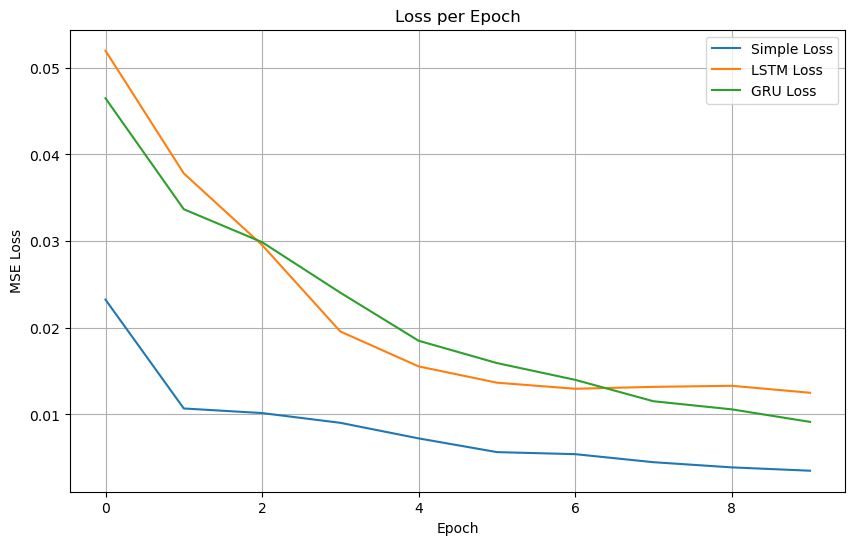

In [42]:
# Plot loss
plt.figure(figsize=(10, 6))
for key in loss_dict:
    plt.plot(loss_dict[key], label=f"{key} Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

Simple - MAE: 49.5674, MSE: 4182.5658
LSTM - MAE: 38.4332, MSE: 2330.8540
GRU - MAE: 37.4519, MSE: 2361.1270


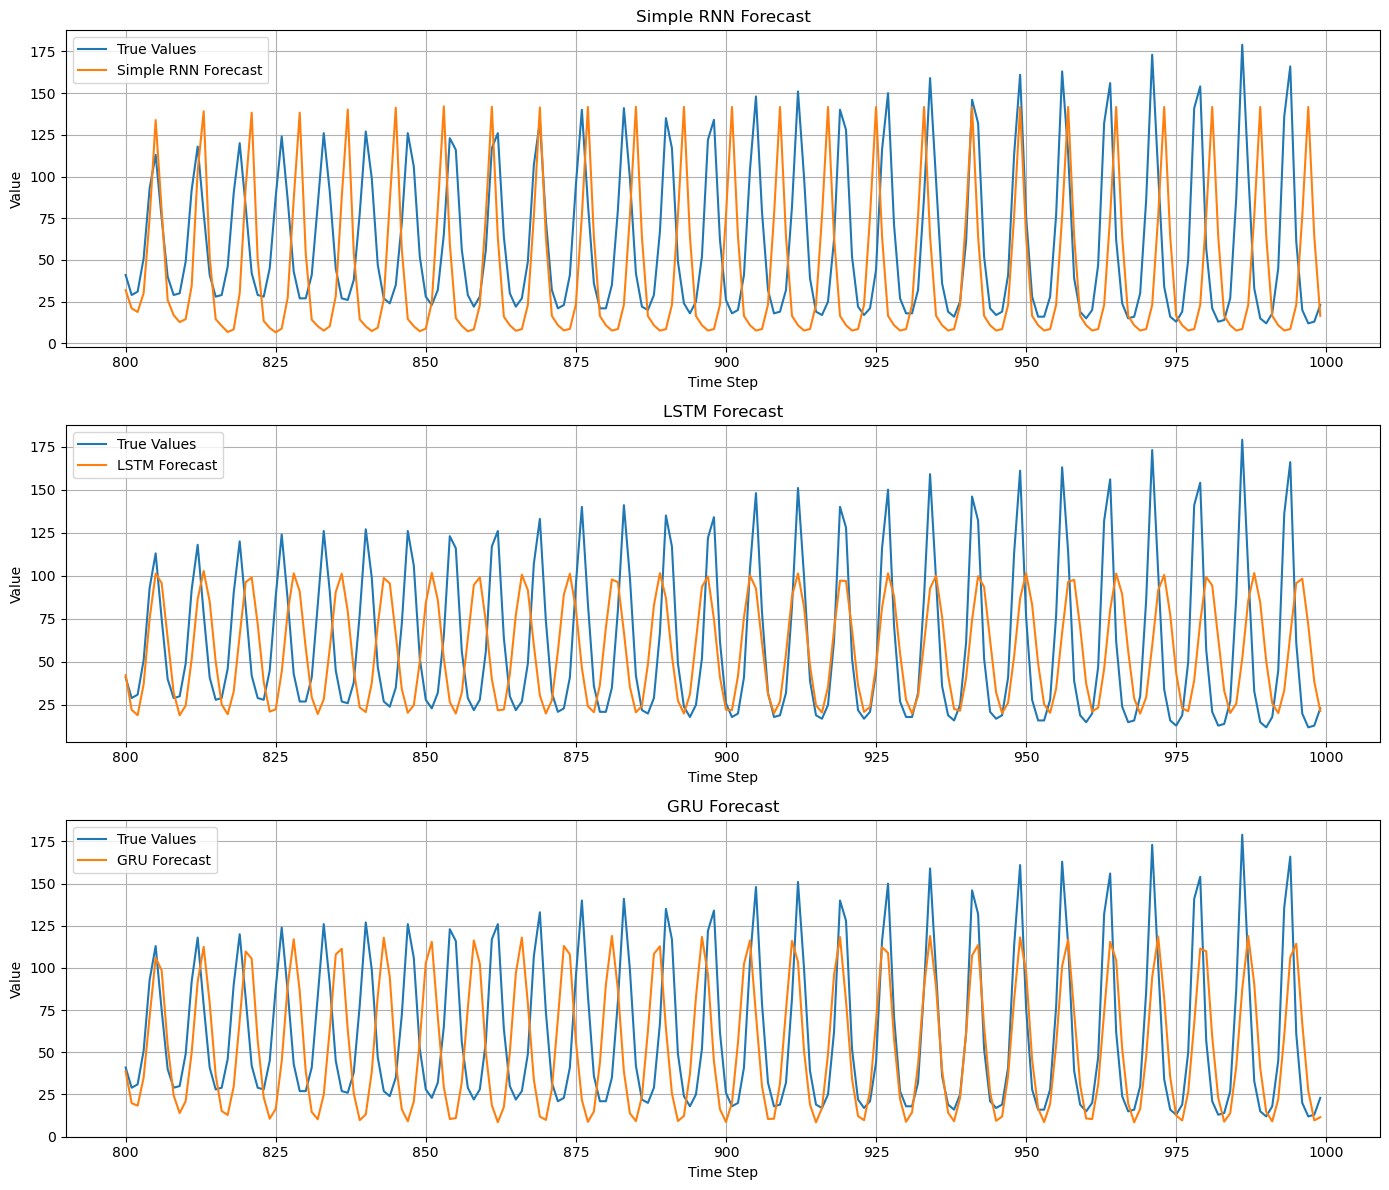

In [43]:
# Print results
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}")

# Plot in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

axs[0].plot(range(800, 1000), y_true_inv, label='True Values')
axs[0].plot(range(800, 1000), preds_Simple_inv, label='Simple RNN Forecast')
axs[0].set_title('Simple RNN Forecast')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(800, 1000), y_true_inv, label='True Values')
axs[1].plot(range(800, 1000), preds_LSTM_inv, label='LSTM Forecast')
axs[1].set_title('LSTM Forecast')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(range(800, 1000), y_true_inv, label='True Values')
axs[2].plot(range(800, 1000), preds_GRU_inv, label='GRU Forecast')
axs[2].set_title('GRU Forecast')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Value')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Main loop used to determine how far we need to look back (this is really slow to run locally, advice is to use Colab for this part)
lookback_values = list(range(5, 105, 5))
forecast_steps = 200

# Store all forecasts
predictions_dict = {'Simple': [], 'LSTM': [], 'GRU': []}

# True future values
y_true = scaler.inverse_transform(dataset[800:].reshape(-1, 1))

# Iterate over lookbacks
for lookback in lookback_values:
    train_data = dataset[:800]

    # Create input/output pairs for training
    X_train, y_train = create_sequences(train_data, lookback)

    if len(X_train) == 0:
        # Skip if not enough data
        predictions_dict['Simple'].append(np.full((200,), np.nan))
        predictions_dict['LSTM'].append(np.full((200,), np.nan))
        predictions_dict['GRU'].append(np.full((200,), np.nan))
        continue

    # Train Simple RNN
    model_simple = ks.Sequential([
        ks.layers.SimpleRNN(128, activation='relu', input_shape=(lookback, 1)),
        ks.layers.Dropout(0.2),
        ks.layers.Dense(1)
    ])
    model_simple.compile(optimizer='adam', loss='mse')
    model_simple.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, shuffle=False)

    # Train LSTM
    model_lstm = ks.Sequential([
        ks.layers.LSTM(128, activation='relu', input_shape=(lookback, 1)),
        ks.layers.Dropout(0.2),
        ks.layers.Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, shuffle=False)

    # Train GRU
    model_gru = ks.Sequential([
        ks.layers.GRU(128, activation='relu', input_shape=(lookback, 1)),
        ks.layers.Dropout(0.2),
        ks.layers.Dense(1)
    ])
    model_gru.compile(optimizer='adam', loss='mse')
    model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, shuffle=False)

    seed_input = train_data[-lookback:]

    # Forecast and inverse transform
    pred_simple = scaler.inverse_transform(recursive_forecast(model_simple, seed_input, forecast_steps, lookback))
    pred_lstm = scaler.inverse_transform(recursive_forecast(model_lstm, seed_input, forecast_steps, lookback))
    pred_gru = scaler.inverse_transform(recursive_forecast(model_gru, seed_input, forecast_steps, lookback))

    predictions_dict['Simple'].append(pred_simple.flatten())
    predictions_dict['LSTM'].append(pred_lstm.flatten())
    predictions_dict['GRU'].append(pred_gru.flatten())


C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\cisva\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` arg

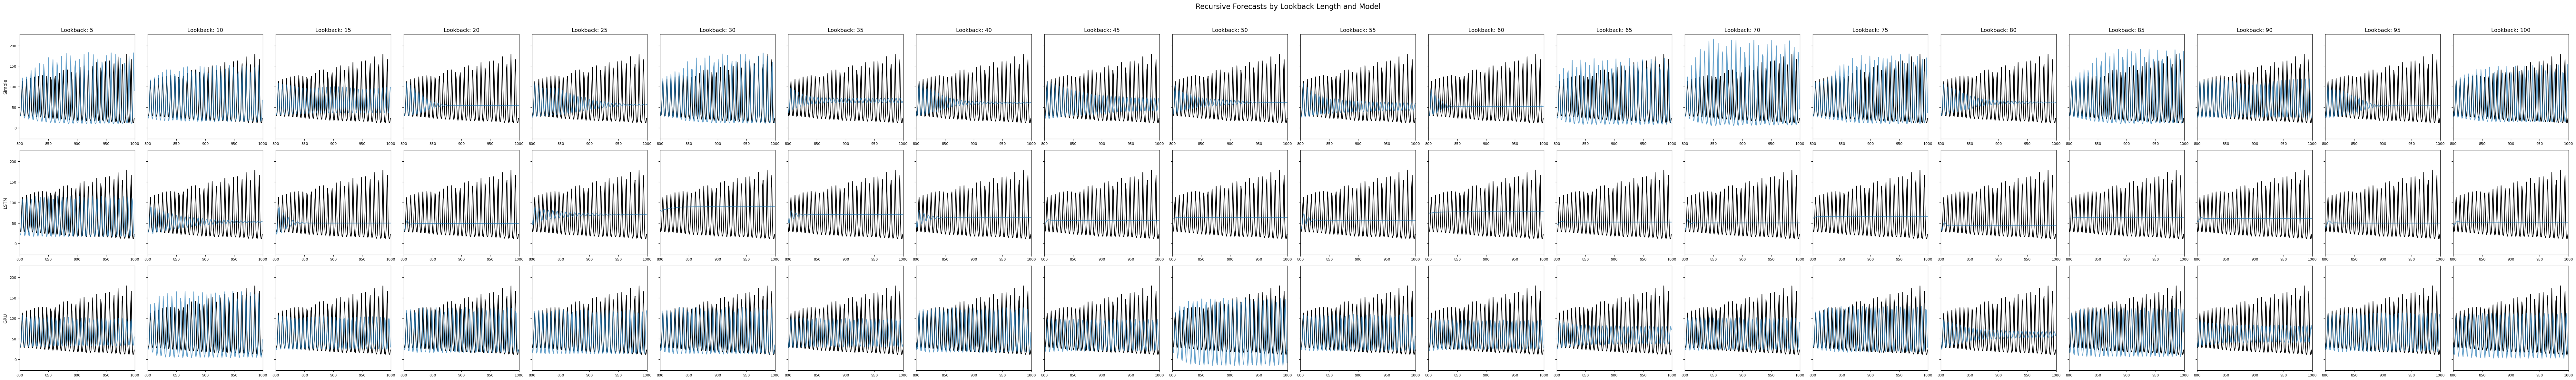

In [24]:
# Plot the predictions for the different lookback values
fig, axes = plt.subplots(3, len(lookback_values), figsize=(4 * len(lookback_values), 12), sharey=True)

model_names = ['Simple', 'LSTM', 'GRU']

for row, model_name in enumerate(model_names):
    for col, lookback in enumerate(lookback_values):
        ax = axes[row, col]
        ax.plot(range(800, 1000), y_true, label='True', color='black')
        ax.plot(range(800, 1000), predictions_dict[model_name][col], label=f'{model_name}', alpha=0.7)
        if row == 0:
            ax.set_title(f'Lookback: {lookback}')
        if col == 0:
            ax.set_ylabel(model_name)
        ax.tick_params(labelsize=8)
        ax.set_xticks([800, 850, 900, 950, 1000])
        ax.set_xlim(800, 1000)

fig.suptitle("Recursive Forecasts by Lookback Length and Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [30]:
mae_results = []
mse_results = []

for row, model_name in enumerate(model_names):
    for col, lookback in enumerate(lookback_values):
        y_pred = predictions_dict[model_name][col]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        
        mae_results.append({'Model': model_name, 'Lookback': lookback, 'MAE': mae})
        mse_results.append({'Model': model_name, 'Lookback': lookback, 'MSE': mse})

mae_df = pd.DataFrame(mae_results)
mse_df = pd.DataFrame(mse_results)

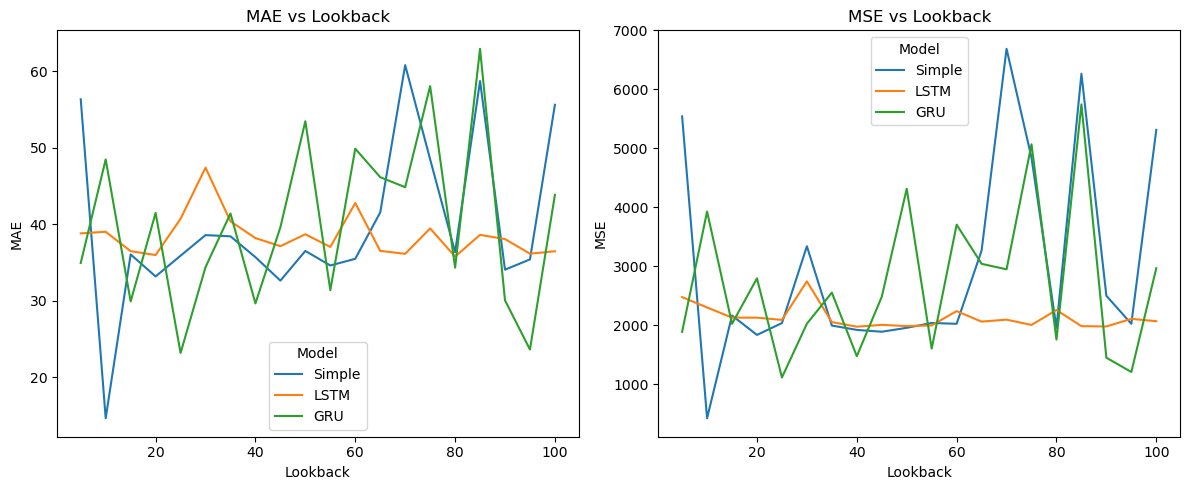

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=mae_df, x='Lookback', y='MAE', hue='Model')
plt.title('MAE vs Lookback')

plt.subplot(1, 2, 2)
sns.lineplot(data=mse_df, x='Lookback', y='MSE', hue='Model')
plt.title('MSE vs Lookback')

plt.tight_layout()
plt.show()

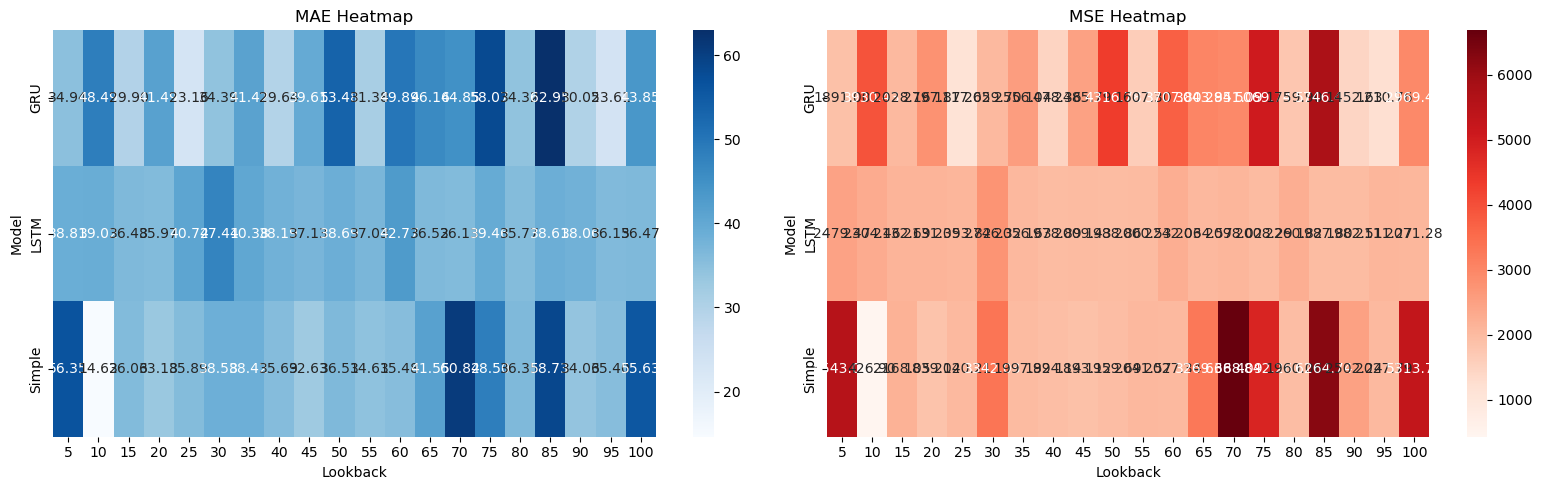

In [32]:
# Pivot for heatmap
mae_pivot = mae_df.pivot(index='Model', columns='Lookback', values='MAE')
mse_pivot = mse_df.pivot(index='Model', columns='Lookback', values='MSE')

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.heatmap(mae_pivot, annot=True, fmt=".2f", cmap='Blues')
plt.title("MAE Heatmap")

plt.subplot(1, 2, 2)
sns.heatmap(mse_pivot, annot=True, fmt=".2f", cmap='Reds')
plt.title("MSE Heatmap")

plt.tight_layout()
plt.show()
